In [1]:
import tensorflow as tf
import os
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [61]:
# パラメタ
learning_rate = 0.001
training_epochs = 200000
batch_size = 64
display_step = 100

# ネットワークパラメタ
dropout = 0.75
NUM_CLASSES = 10
CHANNEL = 1
IMAGE_SIZE = 64
IMAGE_PIXELS = IMAGE_SIZE * IMAGE_SIZE * CHANNEL

x = tf.placeholder(tf.float32, [None, IMAGE_PIXELS])
y = tf.placeholder(tf.float32, [None, NUM_CLASSES])
keep_prob = tf.placeholder(tf.float32)

In [174]:
# データセット
csv_name = 'font_data64/random-all-head10.csv'
fonts = ["futura", "gillsans", "helvetica", "opitma", "andalemono", "arial", "impact", "timenewroman", "trebuchetms", "verdana"]
train_image = []
train_label = []

with open(csv_name, 'r') as f:
    for line in f:
        line = line.rstrip()
        l = line.split(",")
        img = cv2.imread("font_data64/" + l[0], 0)
#         img = cv2.equalizeHist(img)
#         img = cv2.split(img)[1]
#         img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#         train_image.append(img.flatten().astype(np.float32)/255.0)
#         img = cv2.resize(img, (IMAGE_SIZE*IMAGE_SIZE, 1))[0]
#         img = np.vstack(img)
        cv2.imshow("img", img)
        cv2.waitKey(0)
#         img = cv2.resize(img, (IMAGE_SIZE*IMAGE_SIZE, 1))
        img = img.flatten().astype(np.float32)/256.0
#         cv2.imshow("img", img)
#         cv2.waitKey(0)
        cv2.imshow("img", cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE)))
        cv2.waitKey(0)
        train_image.append(img)
#         train_image.append(img)
        tmp = np.zeros(NUM_CLASSES)
        tmp[fonts.index(l[1])] = 1
        train_label.append(tmp)
    train_image = np.asarray(train_image)
    train_label = np.asarray(train_label)
    train_len = len(train_image)

print train_image.shape
print train_label.shape

(10, 4096)
(10, 10)


[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]


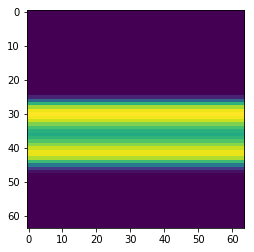

In [163]:
img = train_image[0]
img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
plt.imshow(img)
print train_label[0]

In [90]:
# 畳み込み処理
def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding="SAME")
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

# プーリング処理
def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding="SAME")

# モデル定義
def conv_net(x, weights, biases, dropout):
    x = tf.reshape(x, [-1, IMAGE_SIZE, IMAGE_SIZE, CHANNEL])
    
    # 畳み込み1
    conv1 = conv2d(x, weights["wc1"], biases["bc1"])
    conv1 = maxpool2d(conv1, k=2)
    
    # 畳み込み2
    conv2 = conv2d(conv1, weights["wc2"], biases["bc2"])
    conv2 = maxpool2d(conv2, k=2)
    
    # 全結合
    fc1 = tf.reshape(conv2, [-1, weights["wd1"].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights["wd1"]), biases["bd1"])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, dropout) # dropout を適応
    
    out = tf.add(tf.matmul(fc1, weights["out"]), biases["out"])
    return out

In [91]:
# 重み、バイアス管理用の変数定義
weights = {
    "wc1": tf.Variable(tf.random_normal([5, 5,  1, 32])),
    "wc2": tf.Variable(tf.random_normal([5, 5, 32, 64])),
    "wd1": tf.Variable(tf.random_normal([8*8*64, 1024])),
    "out": tf.Variable(tf.random_normal([1024, NUM_CLASSES]))
}
biases = {
    "bc1": tf.Variable(tf.random_normal([32])),
    "bc2": tf.Variable(tf.random_normal([64])),
    "bd1": tf.Variable(tf.random_normal([1024])),
    "out": tf.Variable(tf.random_normal([NUM_CLASSES]))
}

# モデル
pred = conv_net(x, weights, biases, keep_prob)

# ロス関数
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
# オプティマイザ
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# 評価用モデル
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# 初期化
init = tf.global_variables_initializer()

In [92]:
# 実行
with tf.Session() as sess:
    sess.run(init)
    
    step = 1
    while step * batch_size < training_epochs:
        batch = step * batch_size
        batch_plus = (step+1) * batch_size

        batch_x = train_image[batch:batch_plus]
        batch_y = train_label[batch:batch_plus]
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, keep_prob: dropout})
    
        if (step+1) % display_step == 0:
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x, y: batch_y, keep_prob: 1.})
            print "Epoch:", str(step*batch_size), "Loss=", loss, "Acc=", acc
        
        step += 1

    print "Optimization Finish"
#     print "Testing Accuracy:", \
#     sess.run(accuracy, feed_dict={x: mnist.test.images[:256],
#                                   y: mnist.test.labels[:256],
#                                   keep_prob: 1.})

ValueError: Cannot feed value of shape (64, 64, 64) for Tensor u'Placeholder_3:0', which has shape '(?, 4096)'